In [2]:
import pandas as pd
import numpy as np
import kagglehub
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Setup

In [63]:
# https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci
path = kagglehub.dataset_download("mashlyn/online-retail-ii-uci")
print("Path to dataset files:", path)

file_path = os.path.join(path, 'online_retail_II.csv')
df = pd.read_csv(file_path)

# Loading and preprocessing data
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Dropping rows with CustomerID as NULL
df = df.dropna(subset=['Customer ID'])

# Capping Outliers
df = df[(df['Quantity'] > 0) & (df['Quantity'] < df['Quantity'].quantile(0.99))]

# Defining Training cohorts: Considering Dec-2010, Jan-2011, Feb-2011 and Mar-2011 as training sample cohorts
training_cohorts = [
    ('2010-12-01', '2009-12-01', '2010-11-30', '2011-01-01', '2011-06-30'),
    ('2011-01-01', '2010-01-01', '2010-12-31', '2011-02-01', '2011-07-31'),
    ('2011-02-01', '2010-02-01', '2011-01-31', '2011-03-01', '2011-08-31'),
    ('2011-03-01', '2010-03-01', '2011-02-28', '2011-04-01', '2011-09-30')]

# Defining Out-Of-Time cohorts. Dataset ends ~Dec 9, 2011
holdout_cohorts = [
    ('2011-04-01', '2010-04-01', '2011-03-31', '2011-05-01', '2011-10-31'),
    ('2011-05-01', '2010-05-01', '2011-04-30', '2011-06-01', '2011-11-30'),
    ('2011-06-01', '2010-06-01', '2011-05-31', '2011-07-01', '2011-12-09')]

Path to dataset files: /Users/rohanojha/.cache/kagglehub/datasets/mashlyn/online-retail-ii-uci/versions/3


In [67]:
list(df.columns)

['Invoice',
 'StockCode',
 'Description',
 'Quantity',
 'InvoiceDate',
 'Price',
 'Customer ID',
 'Country']

### Function to calculate the RFM variables and LTV

In [65]:
def calc_rfm_ltv(cohort_month, train_start, train_end, test_start, test_end, is_holdout=False, training_scaler=None):
    cohort_customers = df[(df['InvoiceDate'] >= cohort_month) & 
                         (df['InvoiceDate'] < cohort_month + pd.offsets.MonthEnd(1))]['Customer ID'].unique()
    
    ###################### Filtering customers with sufficient lookback data (at least 2 transactions) ######################
    train = df[(df['InvoiceDate'] >= train_start) & (df['InvoiceDate'] <= train_end) & 
               (df['Customer ID'].isin(cohort_customers))]
    customer_transaction_counts = train.groupby('Customer ID')['Invoice'].nunique()
    valid_customers = customer_transaction_counts[customer_transaction_counts >= 2].index
    train = train[train['Customer ID'].isin(valid_customers)]
    cohort_customers = set(cohort_customers).intersection(valid_customers)

    ###################### Obtaining the country coalesced variable. This can be used in PCA to form clusters ######################
    country_map = {
        'United Kingdom': 'UK', 'EIRE': 'Europe', 'Germany': 'Europe', 'France': 'Europe', 'Belgium': 'Europe',
        'Portugal': 'Europe', 'Netherlands': 'Europe', 'Poland': 'Europe', 'Channel Islands': 'Europe',
        'Spain': 'Europe', 'Cyprus': 'Europe', 'Greece': 'Europe', 'Norway': 'Europe', 'Austria': 'Europe',
        'Sweden': 'Europe', 'Finland': 'Europe', 'Denmark': 'Europe', 'Italy': 'Europe', 'Switzerland': 'Europe',
        'Lithuania': 'Europe', 'Czech Republic': 'Europe', 'USA': 'North America', 'Canada': 'North America',
        'Australia': 'Asia-Pacific', 'Japan': 'Asia-Pacific', 'Singapore': 'Asia-Pacific', 'Thailand': 'Asia-Pacific',
        'Korea': 'Asia-Pacific', 'United Arab Emirates': 'Middle East & Africa', 'Nigeria': 'Middle East & Africa',
        'RSA': 'Middle East & Africa', 'Bahrain': 'Middle East & Africa', 'Israel': 'Middle East & Africa',
        'Saudi Arabia': 'Middle East & Africa', 'Lebanon': 'Middle East & Africa', 'Malta': 'Europe',
        'Iceland': 'Europe', 'Brazil': 'Others', 'West Indies': 'Others', 'Unspecified': 'Others',
        'European Community': 'Others'}
    train['Country_coalesced'] = train['Country'].map(country_map).fillna('Others')
    train['Country_encoded'] = train['Country_coalesced'].map(train['Country_coalesced'].value_counts(normalize=True))

    ###################### Computing the RFM predictors ######################
    rfm = train.groupby('Customer ID').agg({'InvoiceDate': lambda x: (train_end - x.max()).days,
                                            'Invoice': 'nunique', 'Price': lambda x: (x * train.loc[x.index, 'Quantity']).sum(),
                                            'Quantity': 'sum', 'Country_encoded': 'first'
    }).rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'Price': 'Monetary','Quantity': 'TotalQuantity'})
    
    ###################### Computing LTV (predictor) ######################
    test = df[(df['InvoiceDate'] >= test_start) & (df['InvoiceDate'] <= test_end) & 
              (df['Customer ID'].isin(cohort_customers))]
    ltv = test.groupby('Customer ID')[['Quantity', 'Price']].apply(
        lambda x: (x['Quantity'] * x['Price']).sum(), include_groups=False).rename('LTV_UnTrsf')
    rfm = rfm.join(ltv, how='left').fillna(0)
    
    rfm['LTV'] = np.log1p(rfm['LTV_UnTrsf']) # Log-transforming LTV to scale

    ###################### Applying Scaler Transformation if holdout sample ######################
    features = ['Recency', 'Frequency', 'Monetary', 'TotalQuantity', 'Country_encoded']
    if is_holdout:
        rfm_scaled = training_scaler.transform(rfm[features])
        rfm[features] = rfm_scaled
        return rfm
    else:
        return rfm

### Plotting LTV vs PC1 for both the Clusters(A Visual Representation)
### Quantifying the findings (Statistical results for a definitive answer)

In [69]:
def plot_PCA(rfm):
    sns.lmplot(data=rfm, x="LTV", y="PC1", hue="Cluster", ci=None, palette="Set1", scatter_kws={"alpha": 0.4},height=5,aspect=3)
    plt.title(f'LTV vs PC1(Combined Cohort)')
    plt.xlabel("LTV")
    plt.ylabel("PC1")
    plt.show()

def plot_LTV_Hist(rfm):
    # Untransformed LTV Histogram
    plt.figure(figsize=(8,4))
    sns.histplot(data=df_rfm, x="LTV_UnTrsf", bins=75, kde = True)
    plt.xlabel("LTV Raw")
    plt.ylabel("Frequency")
    plt.show()

    # Log-Transformed LTV Histogram
    plt.figure(figsize=(8,4))
    sns.histplot(data=df_rfm, x="LTV", bins=75, kde = True)
    plt.xlabel("LTV Log-Transformed")
    plt.ylabel("Frequency")
    plt.show()

def evaluate_models(cluster_nmbr, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)

    ridge = Ridge()
    ridge.fit(X_train, y_train)
    ridge_preds = ridge.predict(X_test)
    # ridge.fit(X, y)
    # ridge_preds = ridge.predict(X)

    nn = MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=1000, random_state=31)
    nn = MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=1000)
    nn.fit(X_train, y_train)
    nn_preds = nn.predict(X_test)
    # nn.fit(X, y)
    # nn_preds = nn.predict(X)

    metrics = lambda y_true, y_pred: {'R2': r2_score(y_true, y_pred),
                                      'RMSE': mean_squared_error(y_true, y_pred, squared=False)}

    return {'Cluster':cluster_nmbr, 'Ridge': metrics(y_test, ridge_preds), 'NeuralNet': metrics(y_test, nn_preds)}
    # return {'Cluster':cluster_nmbr, 'Ridge': metrics(y, ridge_preds), 'NeuralNet': metrics(y, nn_preds)}

### Processing training cohorts

Variance Explained by PC1: 56.0383920458814

Training Cluster Counts: Cluster
0    2139
1     329
Name: count, dtype: int64


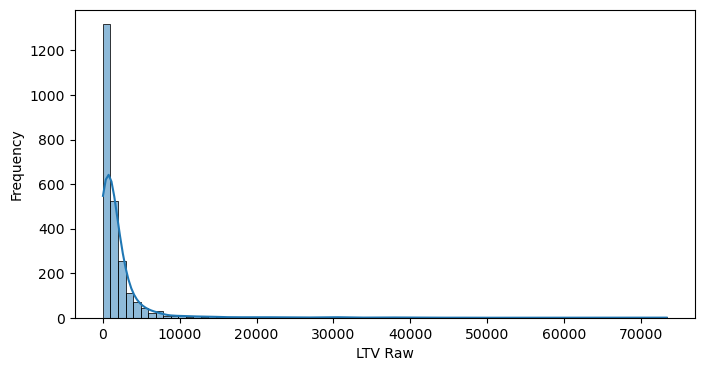

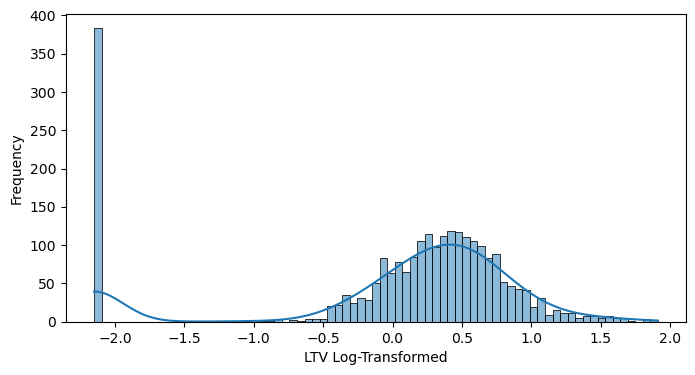

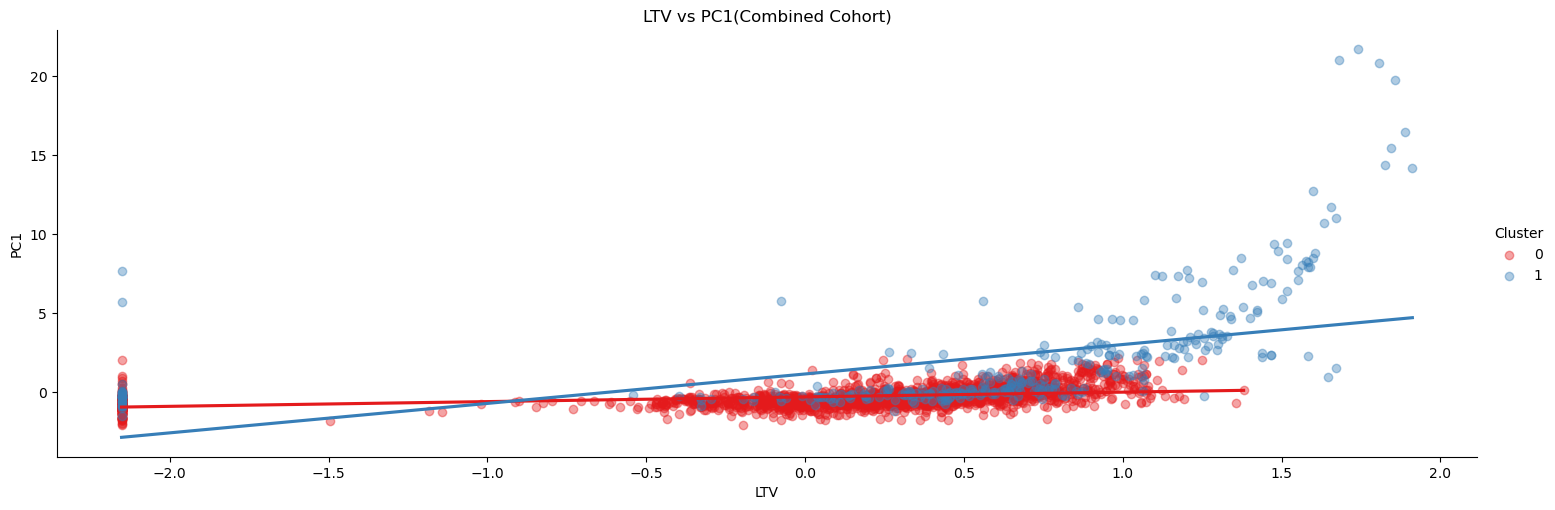

Model Evaluation Results:


,Cluster,Ridge_R2,Ridge_RMSE,NN_R2,NN_RMSE
0,Cluster 0,0.23764,0.881088,0.268210,0.863241
1,Cluster 1,0.25596,0.963530,0.437252,0.837962


In [71]:
# Process training cohorts
df_rfm = pd.DataFrame()
for cohort_month, train_start, train_end, test_start, test_end in training_cohorts:
    cohort_month = pd.to_datetime(cohort_month)
    train_start = pd.to_datetime(train_start)
    train_end = pd.to_datetime(train_end)
    test_start = pd.to_datetime(test_start)
    test_end = pd.to_datetime(test_end)
    
    rfm = calc_rfm_ltv(cohort_month, train_start, train_end, test_start, test_end)
    df_rfm = pd.concat([df_rfm, rfm.assign(Cohort=cohort_month)], ignore_index=True)

scaler = StandardScaler()
features = ['Recency', 'Frequency', 'Monetary', 'TotalQuantity', 'Country_encoded']

# Standardizing predictors
df_rfm_scaled = scaler.fit_transform(df_rfm[features])
df_rfm[features] = df_rfm_scaled

# Standardizing the target variable (LTV)
ltv_scaler = StandardScaler()
df_rfm['LTV'] = ltv_scaler.fit_transform(df_rfm[['LTV']])

# Clustering predictors on combined training data
kmeans = KMeans(n_clusters=2, random_state=42)
df_rfm['Cluster'] = kmeans.fit_predict(df_rfm_scaled)
# df_rfm['Cluster'] = kmeans.fit_predict(df_rfm[features]) # Forming clusters on un-standardized predictors

# Computing PCA on combined training data
pca = PCA(n_components=1)
df_rfm['PC1'] = pca.fit_transform(df_rfm_scaled)
print(f"Variance Explained by PC1: {pca.explained_variance_ratio_[0]*100}\n")
# df_rfm['PC1'] = pca.fit_transform(df_rfm[features]) # Forming PC1 on un-standardized predictors

# Diagnostic: Checking training cluster distribution
print("Training Cluster Counts:", df_rfm['Cluster'].value_counts())

# Plotting LTV Histograms
plot_LTV_Hist(df_rfm)

# Plotting PC1 vs. LTV (using your plot_PCA function)
plot_PCA(df_rfm)

# Evaluating models (using your evaluate_models function)
cluster_0 = df_rfm[df_rfm['Cluster'] == 0]
cluster_1 = df_rfm[df_rfm['Cluster'] == 1]
results_cluster_0 = evaluate_models('Cluster 0', cluster_0[['PC1']], cluster_0['LTV'])
results_cluster_1 = evaluate_models('Cluster 1', cluster_1[['PC1']], cluster_1['LTV'])

# Displaying evaluation results
df_t = pd.DataFrame(columns=('Cluster', 'Ridge_R2', 'Ridge_RMSE', 'NN_R2', 'NN_RMSE'))
for i in [results_cluster_0, results_cluster_1]:
    df_t = pd.concat([df_t, pd.DataFrame([{
        'Cluster': i['Cluster'],
        'Ridge_R2': i['Ridge']['R2'],
        'Ridge_RMSE': i['Ridge']['RMSE'],
        'NN_R2': i['NeuralNet']['R2'],
        'NN_RMSE': i['NeuralNet']['RMSE']
    }])], ignore_index=True)
print("Model Evaluation Results:")
df_t

#### From the above, we have the following observations:
#### - For cluster 0: Ridge and Neural Net seem to be performing in a similar way(considering RMSE & R-Sq). But since Neural Net seem to be performing better, deciding to use the same.
#### - For cluster 1: Here Neural Network seems to be the clear choice of methodology. The RMSE & R-Sq(NN) are far superior than Ridge's.
#### - We also observe that the total variance explained by the 1st Principal Component (PC1) is 56% and the above results are just a reflection of the models' behaviours per each cluster. Intending to use all the raw scaled variables instead of the PCs to capture as much variance as possible

### Training Models

In [73]:
def train_models(df_rfm):
    features = ['Recency', 'Frequency', 'Monetary', 'TotalQuantity', 'Country_encoded']
    cluster_models = {}
    for cluster in df_rfm['Cluster'].unique():
        cluster_data = df_rfm[df_rfm['Cluster'] == cluster]
        X = cluster_data[features]
        y = cluster_data['LTV']
        
        if len(X) < 10:
            print(f"Cluster {cluster} has too few customers: {len(X)}")
            continue
        
        # Model selection based on PC1-LTV evaluation
        if cluster == 0:
            # model = Ridge()
            model = Sequential([
                Dense(16, activation='relu', input_shape=(X.shape[1],)), Dense(8, activation='relu'), Dense(1, activation='linear')])
            model.compile(optimizer='adam', loss='mse')
        else:
            # model = Ridge()
            model = Sequential([
                Dense(16, activation='relu', input_shape=(X.shape[1],)), Dense(8, activation='relu'), Dense(1, activation='linear')])
            model.compile(optimizer='adam', loss='mse')
        
        # Train model
        if isinstance(model, Ridge):
            model.fit(X, y)
        else:
            model.fit(X, y, epochs=10, batch_size=32, verbose=0)
        cluster_models[cluster] = model
    return df_rfm, cluster_models

df_rfm1, models = train_models(df_rfm)

In [75]:
# Displaying results (single train time frame)
y_true = df_rfm1['LTV']
X = df_rfm1[features]
y_pred = []

for i in range(len(df_rfm1)):
    cluster = df_rfm1['Cluster'].iloc[i]
    model = models.get(cluster, Ridge(random_state=42, alpha=0.1))
    X_row = X.iloc[[i]]
    if isinstance(model, Ridge):
        pred = model.predict(X_row)[0]
    else:
        pred = model.predict(X_row, verbose=0).flatten()[0]
    y_pred.append(pred)

y_true_log = ltv_scaler.inverse_transform(y_true.values.reshape(-1, 1)).flatten()
y_pred_log = ltv_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()

mse = mean_squared_error(y_true_log, y_pred_log)
r2 = r2_score(y_true_log, y_pred_log)
train_predictions = [{'Train_Period': '2010-12 to 2011-03', 'Train_MSE': mse, 'Train_R2': r2}]

# Display holdout results
print("\nHoldout Results (Train Predictions, Overlapping Customers, Log-Scale, Combined Train Period):")
print(pd.DataFrame(train_predictions))


Holdout Results (Train Predictions, Overlapping Customers, Log-Scale, Combined Train Period):
         Train_Period  Train_MSE  Train_R2
0  2010-12 to 2011-03   5.206777  0.315042


### Processing holdout cohorts

Holdout Cohort 2011-04 Cluster Counts: Cluster
0    565
1     50
Name: count, dtype: int64
Holdout Cohort 2011-05 Cluster Counts: Cluster
0    713
1     66
Name: count, dtype: int64
Holdout Cohort 2011-06 Cluster Counts: Cluster
0    648
1     77
Name: count, dtype: int64

Overall Holdout Cluster Counts: Cluster
0    1926
1     193
Name: count, dtype: int64


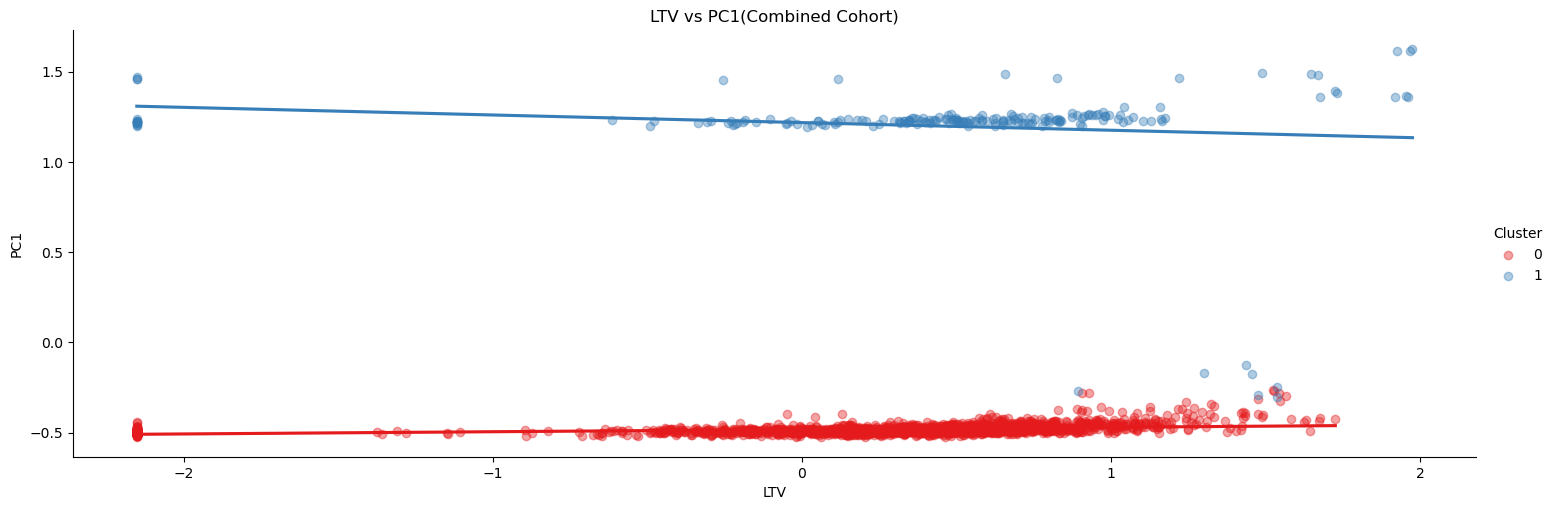

In [77]:
all_rfm_holdout = []
for cohort_month, train_start, train_end, test_start, test_end in holdout_cohorts:
    cohort_month = pd.to_datetime(cohort_month)
    train_start = pd.to_datetime(train_start)
    train_end = pd.to_datetime(train_end)
    test_start = pd.to_datetime(test_start)
    test_end = pd.to_datetime(test_end)
    
    rfm_test = calc_rfm_ltv(cohort_month, train_start, train_end, test_start, test_end, 
                            is_holdout=True, training_scaler=scaler)
    # rfm_test = calc_rfm_ltv(cohort_month, train_start, train_end, test_start, test_end, is_holdout=True)
    if rfm_test is not None:
        rfm_test_scaled = scaler.transform(rfm_test[features])
        rfm_test['Cluster'] = kmeans.predict(rfm_test_scaled)
        rfm_test['PC1'] = pca.transform(rfm_test_scaled)
        rfm_test['LTV'] = ltv_scaler.transform(rfm_test[['LTV']])  # Standardizing LTV
        print(f"Holdout Cohort {cohort_month.strftime('%Y-%m')} Cluster Counts:", pd.Series(rfm_test['Cluster']).value_counts())
        all_rfm_holdout.append(rfm_test.assign(Cohort=cohort_month))

all_rfm_holdout = pd.concat(all_rfm_holdout, ignore_index=True)

# Diagnostic: Check overall holdout cluster distribution
print("\nOverall Holdout Cluster Counts:", all_rfm_holdout['Cluster'].value_counts())

# Plot PC1 vs. LTV for holdout data
plot_PCA(all_rfm_holdout)

In [79]:
# Applying trained models to holdout sample (single test time frame)
y_true = all_rfm_holdout['LTV']
X = all_rfm_holdout[features]
y_pred = []

for i in range(len(all_rfm_holdout)):
    cluster = all_rfm_holdout['Cluster'].iloc[i]
    model = models.get(cluster, Ridge(random_state=42, alpha=0.1))
    X_row = X.iloc[[i]]
    if isinstance(model, Ridge):
        pred = model.predict(X_row)[0]
    else:
        pred = model.predict(X_row, verbose=0).flatten()[0]
    y_pred.append(pred)

y_true_log = ltv_scaler.inverse_transform(y_true.values.reshape(-1, 1)).flatten()
y_pred_log = ltv_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()

mse = mean_squared_error(y_true_log, y_pred_log)
r2 = r2_score(y_true_log, y_pred_log)
holdout_predictions = [{'Test_Period': '2011-04 to 2011-06', 'Holdout_MSE': mse, 'Holdout_R2': r2}]

# Display holdout results
print("\nHoldout Results (Out-of-Time Predictions, Overlapping Customers, Log-Scale, Combined Test Period):")
print(pd.DataFrame(holdout_predictions))


Holdout Results (Out-of-Time Predictions, Overlapping Customers, Log-Scale, Combined Test Period):
          Test_Period  Holdout_MSE  Holdout_R2
0  2011-04 to 2011-06     4.641302    0.240505
